In [1]:
import os
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_etf_data(ETF):
    NNtype = "RNN"
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
    
    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'
    

    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    return (trainloader, trainmu, trainsigma), (validloader, validmu, validsigma), (testloader, testmu, testsigma)


In [3]:
import torch.nn as nn 

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers= 1)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    

In [4]:
def train_model(model, traindata, validdata, params):
    train_loss = []
    val_loss = []
    
    epochs = params["epochs"]
    lr = params["lr"]
    trainloader = traindata[0]
    mu_train = traindata[1]
    sigma_train = traindata[2]
    validloader = validdata[0]
    mu_val = validdata[1]
    sigma_val = validdata[2]
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    for i in range(epochs):
        for seq, labels in trainloader:
            model.train()
            optimizer.zero_grad()
            
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            
            y_pred = model(seq.squeeze())
            
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
          
      ###############################
      ###########Validation##########
      ###############################
        if i%2 == 0:
            model.eval()
            with torch.no_grad():
                loss_valid = 0
                for seq, labels in validloader:
                    y_pred = model(seq.squeeze())
                    #loss_valid += loss_function((y_pred ), (labels))
                    loss_valid += loss_function((y_pred * sigma_val) + mu_val, (labels * sigma_val) + mu_val )

                val_loss.append(loss_valid.item())
                loss_train = 0 
                for seq, labels in trainloader:
                    y_pred = model(seq.squeeze())
                    #loss_train += loss_function((y_pred), labels )

                    loss_train += loss_function((((y_pred) * sigma_train) + mu_train), (labels * sigma_train) + mu_train)
                train_loss.append(loss_train.item())
            print(f'epoch: {i:3} train_loss: {loss_train:10.10f} val_loss: {loss_valid:10.10f} ')
            
#     plt.plot(train_loss)
#     plt.plot(val_loss)

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test

def evaluate_model(model, testdata):
    testloader = testdata[0]
    mu = np.array(testdata[1])
    sigma = np.array(testdata[2])
    valid_targets = []
    valid_preds = []
    with torch.no_grad():
        for seq, target in testloader:
            valid_preds.append(model(seq.squeeze()))
            valid_targets += target.numpy().tolist()


     
    validRMSE = np.sqrt(mean_squared_error((valid_targets * sigma) + mu, (valid_preds*sigma) + mu))
    validMAE = mean_absolute_error((valid_targets * sigma) + mu, (valid_preds*sigma + mu))
    validMAPE = mean_absolute_percentage_error((np.array(valid_targets) * sigma) + mu , (np.array(valid_preds) * sigma) + mu)
    validTheilU = theilU((np.array(valid_targets)* sigma) + mu , (np.array(valid_preds) * sigma) + mu)

    print("MAE : {:.4f} |  MAPE  : {:.4f} |  RMSE : {:.5f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
    
    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    dataDf = utils.load_file(os.path.join("data", ETF, "RNN", "Test.pkl"))
    plt.plot(dataDf.index, valid_targets, label="Targets")
    plt.plot(dataDf.index, valid_preds, label="Predictions")
    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - LSTM")
    plt.show()
    
    return {"MAE": validMAE, "RMSE": validRMSE, "MAPE": validMAPE, "Theil-U":validTheilU}

def predict(model, testdata):
    testloader = testdata[0]
    mu = testdata[1]
    sigma = testdata[2]
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for seq, target in testloader:
            predicted_labels.append(model(seq.squeeze()))
    return  (predicted_labels * np.array(sigma)) + np.array(mu)

### Generating Table 4 with baseline parameters and predictions


==========SPY==========
epoch:   0 train_loss: 0.0689807013 val_loss: 0.0122210234 
epoch:   2 train_loss: 0.0685147271 val_loss: 0.0121738873 
epoch:   4 train_loss: 0.0689880475 val_loss: 0.0121355299 
epoch:   6 train_loss: 0.0672129169 val_loss: 0.0122744525 
epoch:   8 train_loss: 0.0686718300 val_loss: 0.0121353325 
epoch:  10 train_loss: 0.0665113181 val_loss: 0.0123577062 
epoch:  12 train_loss: 0.0650051609 val_loss: 0.0125349946 
epoch:  14 train_loss: 0.0685270801 val_loss: 0.0129670305 
epoch:  16 train_loss: 0.1824020445 val_loss: 0.0276291780 
epoch:  18 train_loss: 0.0873323753 val_loss: 0.0178313013 
epoch:  20 train_loss: 0.1725869924 val_loss: 0.0302399397 
epoch:  22 train_loss: 0.2631498575 val_loss: 0.0306705423 
epoch:  24 train_loss: 0.0664185435 val_loss: 0.0164254084 
epoch:  26 train_loss: 0.0659779981 val_loss: 0.0153856194 
epoch:  28 train_loss: 0.0749375746 val_loss: 0.0131090330 
epoch:  30 train_loss: 0.0764959380 val_loss: 0.0216804929 
epoch:  32 train

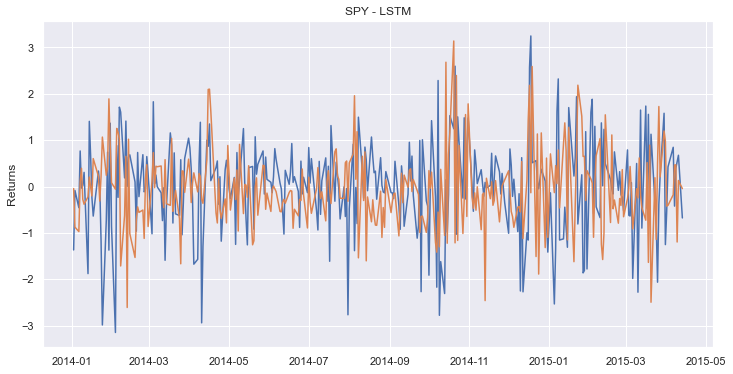

{'MAE': 0.00732419179251163, 'RMSE': 0.009455109003762516, 'MAPE': 369.7392620093301, 'Theil-U': 0.6966966542587686}
==========DIA==========
epoch:   0 train_loss: 0.0570358150 val_loss: 0.0102245351 
epoch:   2 train_loss: 0.0566937476 val_loss: 0.0102851288 
epoch:   4 train_loss: 0.0562632792 val_loss: 0.0103454776 
epoch:   6 train_loss: 0.0556542873 val_loss: 0.0104391845 
epoch:   8 train_loss: 0.0551721863 val_loss: 0.0104595283 
epoch:  10 train_loss: 0.0932888538 val_loss: 0.0103787212 
epoch:  12 train_loss: 0.0544877611 val_loss: 0.0105303731 
epoch:  14 train_loss: 0.0541121103 val_loss: 0.0104644047 
epoch:  16 train_loss: 0.0524228662 val_loss: 0.0105505837 
epoch:  18 train_loss: 0.0502172187 val_loss: 0.0106654298 
epoch:  20 train_loss: 0.0496535227 val_loss: 0.0107282968 
epoch:  22 train_loss: 0.0481540225 val_loss: 0.0109559586 
epoch:  24 train_loss: 0.0556190424 val_loss: 0.0114448685 
epoch:  26 train_loss: 0.0501554906 val_loss: 0.0121357460 
epoch:  28 train_lo

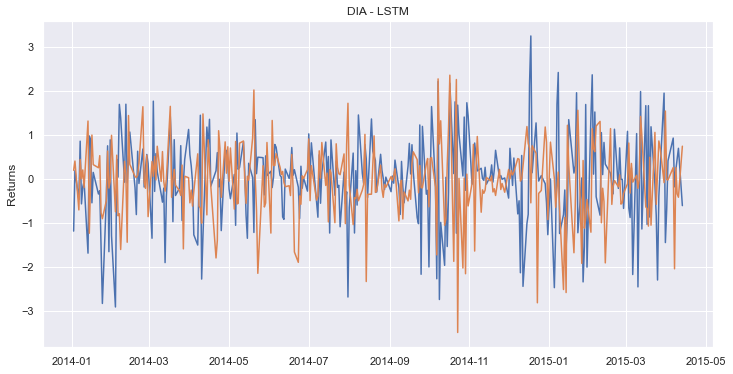

{'MAE': 0.0072578734518958824, 'RMSE': 0.009518326936965443, 'MAPE': 178442977.76165524, 'Theil-U': 0.7119156711876118}
==========QQQ==========
epoch:   0 train_loss: 0.0793229192 val_loss: 0.0148933390 
epoch:   2 train_loss: 0.0785347968 val_loss: 0.0148505168 
epoch:   4 train_loss: 0.0776561797 val_loss: 0.0147885559 
epoch:   6 train_loss: 0.0765553340 val_loss: 0.0147835854 
epoch:   8 train_loss: 0.0751246735 val_loss: 0.0148781613 
epoch:  10 train_loss: 0.0741155297 val_loss: 0.0153866271 
epoch:  12 train_loss: 0.0761093944 val_loss: 0.0160144009 
epoch:  14 train_loss: 0.0750456154 val_loss: 0.0165047757 
epoch:  16 train_loss: 0.0761621594 val_loss: 0.0161132142 
epoch:  18 train_loss: 0.0729270577 val_loss: 0.0169318449 
epoch:  20 train_loss: 0.0738422498 val_loss: 0.0165622067 
epoch:  22 train_loss: 0.0729147047 val_loss: 0.0165907908 
epoch:  24 train_loss: 0.0720143914 val_loss: 0.0172111094 
epoch:  26 train_loss: 0.0739168674 val_loss: 0.0177714899 
epoch:  28 train

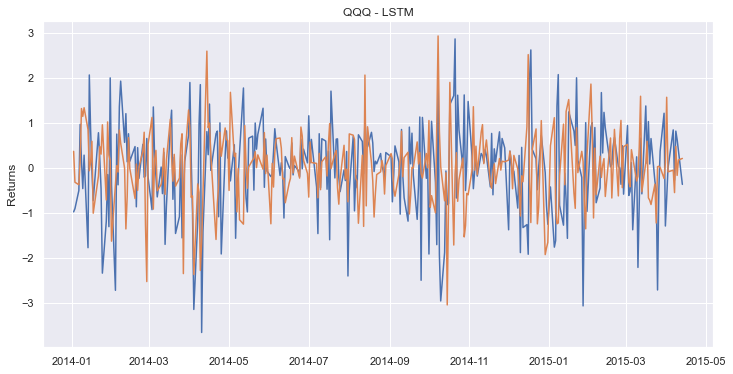

{'MAE': 0.008212339914812251, 'RMSE': 0.011044693650799417, 'MAPE': 202950287.06973934, 'Theil-U': 0.6932765746476941}


In [6]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4_baseline = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
modelPredictions_baseline = {}

for ETF in ETF_params:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    
    modelPredictions_baseline[ETF] = predicted
    
    Table4_baseline[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
    print(results)

In [7]:
Table4_baseline

,Statistic,SPY,DIA,QQQ
0,MAE,0.007324,7.257873e-03,8.212340e-03
1,MAPE,369.739262,1.784430e+08,2.029503e+08
2,RMSE,0.009455,9.518327e-03,1.104469e-02
3,THEIL-U,0.696697,7.119157e-01,6.932766e-01


### SAME TEST WITH DROPOUT AND L2 REGULARIZATION




==========SPY==========
epoch:   0 train_loss: 0.0689790770 val_loss: 0.0122157568 
epoch:   2 train_loss: 0.0685691983 val_loss: 0.0121928556 
epoch:   4 train_loss: 0.0673862025 val_loss: 0.0123762330 
epoch:   6 train_loss: 0.0676067770 val_loss: 0.0123945298 
epoch:   8 train_loss: 0.0667762831 val_loss: 0.0124604581 
epoch:  10 train_loss: 0.0672550574 val_loss: 0.0124442829 
epoch:  12 train_loss: 0.1841795743 val_loss: 0.0335964076 
epoch:  14 train_loss: 0.0814308077 val_loss: 0.0139030842 
epoch:  16 train_loss: 0.2368857265 val_loss: 0.0299460869 
epoch:  18 train_loss: 0.0737025887 val_loss: 0.0140469465 
epoch:  20 train_loss: 0.0710864365 val_loss: 0.0140885543 
epoch:  22 train_loss: 0.0641024485 val_loss: 0.0140174320 
epoch:  24 train_loss: 0.0783797950 val_loss: 0.0143752042 
epoch:  26 train_loss: 0.0649944767 val_loss: 0.0140552651 
epoch:  28 train_loss: 0.0618111305 val_loss: 0.0143986456 
epoch:  30 train_loss: 0.0694189072 val_loss: 0.0136890588 
epoch:  32 train

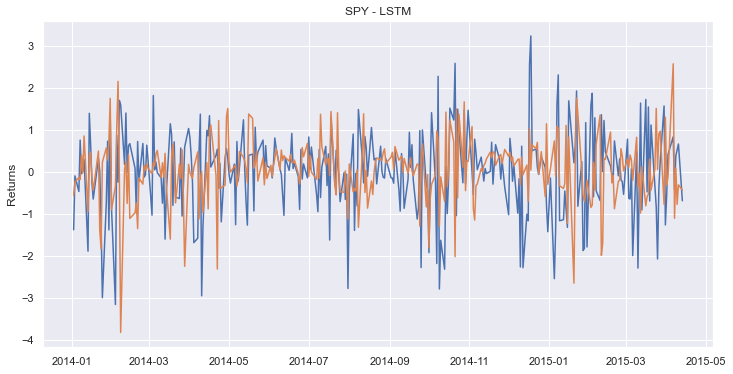

{'MAE': 0.006558275147380719, 'RMSE': 0.008998676393462812, 'MAPE': 245.17532375221677, 'Theil-U': 0.6938692128463672}
==========DIA==========
epoch:   0 train_loss: 0.0570186973 val_loss: 0.0102269910 
epoch:   2 train_loss: 0.0566746891 val_loss: 0.0102870632 
epoch:   4 train_loss: 0.0562658608 val_loss: 0.0103429789 
epoch:   6 train_loss: 0.0556534119 val_loss: 0.0104173757 
epoch:   8 train_loss: 0.0558986291 val_loss: 0.0104178442 
epoch:  10 train_loss: 0.0546514764 val_loss: 0.0105105098 
epoch:  12 train_loss: 0.0545109175 val_loss: 0.0104012648 
epoch:  14 train_loss: 0.0562397279 val_loss: 0.0106759463 
epoch:  16 train_loss: 0.0527853146 val_loss: 0.0107575636 
epoch:  18 train_loss: 0.0562085882 val_loss: 0.0111905998 
epoch:  20 train_loss: 0.0507443659 val_loss: 0.0112874145 
epoch:  22 train_loss: 0.0507805385 val_loss: 0.0110012973 
epoch:  24 train_loss: 0.0468099937 val_loss: 0.0115669901 
epoch:  26 train_loss: 0.0558643341 val_loss: 0.0141978832 
epoch:  28 train_

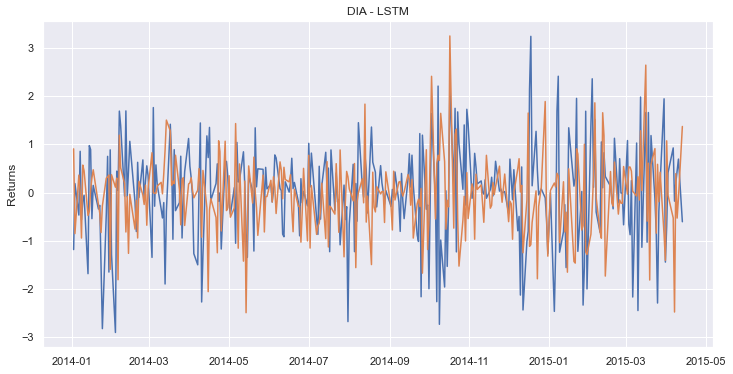

{'MAE': 0.006947575816846044, 'RMSE': 0.009098675438061877, 'MAPE': 152628218.61479393, 'Theil-U': 0.703338115177937}
==========QQQ==========
epoch:   0 train_loss: 0.0792806596 val_loss: 0.0148828728 
epoch:   2 train_loss: 0.0783710629 val_loss: 0.0148492288 
epoch:   4 train_loss: 0.0778126195 val_loss: 0.0147710377 
epoch:   6 train_loss: 0.0762692466 val_loss: 0.0148710990 
epoch:   8 train_loss: 0.0753170401 val_loss: 0.0149185741 
epoch:  10 train_loss: 0.0735632926 val_loss: 0.0153581062 
epoch:  12 train_loss: 0.0721386001 val_loss: 0.0156782493 
epoch:  14 train_loss: 0.0709094927 val_loss: 0.0165008176 
epoch:  16 train_loss: 0.0778275132 val_loss: 0.0173486546 
epoch:  18 train_loss: 0.0771156549 val_loss: 0.0154987564 
epoch:  20 train_loss: 0.0736312643 val_loss: 0.0164704714 
epoch:  22 train_loss: 0.0764170662 val_loss: 0.0162252057 
epoch:  24 train_loss: 0.0753759146 val_loss: 0.0166119542 
epoch:  26 train_loss: 0.0775524378 val_loss: 0.0186141357 
epoch:  28 train_l

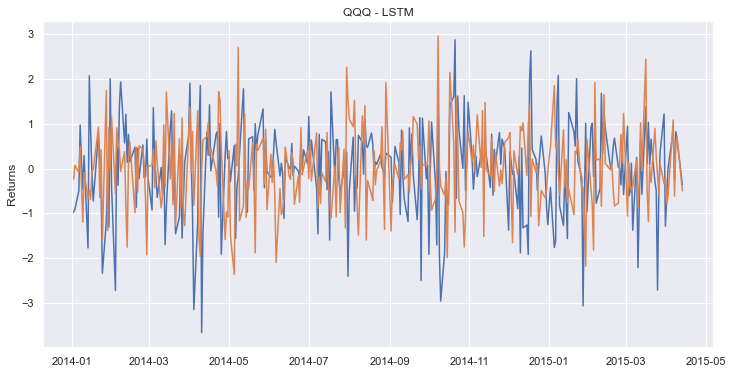

{'MAE': 0.008993611746282947, 'RMSE': 0.011781176510938773, 'MAPE': 74723176.61390567, 'Theil-U': 0.7108154191767407}


In [8]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4 = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
modelPredictions = {}

for ETF in ETF_params:
    
    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    
    modelPredictions[ETF] = predicted
    Table4[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
    print(results)


In [9]:
Table4

,Statistic,SPY,DIA,QQQ
0,MAE,0.006558,6.947576e-03,8.993612e-03
1,MAPE,245.175324,1.526282e+08,7.472318e+07
2,RMSE,0.008999,9.098675e-03,1.178118e-02
3,THEIL-U,0.693869,7.033381e-01,7.108154e-01


# Plot

In [ ]:
sns.set()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,6))

ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

for ETF in ["SPY", "DIA", "QQQ"]:
#     Totaldf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Total.pkl")
    # date column already as index
    Traindf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Train.pkl")
    Validdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Valid.pkl")
    Testdf = pd.read_pickle("data/" + ETF + "/ARMA/" + "Test.pkl") # out of sample
    
    # set frequency
    Traindf = Traindf.asfreq('d')
    Validdf = Validdf.asfreq('d')
    Testdf = Testdf.asfreq('d')
    
    # define targets
    trainTarget = Traindf['Return'].copy()
    validTarget = Validdf['Return'].copy()
    testTarget = Testdf['Return'].copy()
    
    # fit the model
    if ETF == "SPY":
        ARIMA_order = (8,0,8)
        AX = ax1 # for the plot
    elif ETF == "DIA":
        ARIMA_order = (10,0,10)
        AX = ax2 # for the plot
    else:
        ARIMA_order = (7,0,7)
        AX = ax3 # for the plot
    
    model = ARIMA(testTarget, order=ARIMA_order, missing='drop') # fit on the out of sample dataset => testTarget
    model_fit = model.fit(disp=0)
    
    fittedDf = pd.DataFrame({"Predictions":model_fit.predict()})
    
    # saving prediction
    os.makedirs(os.path.join("models_norm", ETF, "ARMA"), exist_ok=True)
    utils.save_file(fittedDf, os.path.join("models_norm", ETF, "ARMA", "Predictions.pkl"))
    
    # plot actual vs fitted
#     fittedDf = pd.DataFrame({"Predictions":model_fit.predict()})

#     fig, ax = plt.subplots(figsize = (12,6))
#     fig = sns.lineplot(x=Testdf.index, y='Return', data=Testdf, label="Targets")
#     sns.lineplot(x=fittedDf.index, y='Predictions', data=fittedDf, label="Predictions")
#     ax.set_ylabel('Returns')
#     ax.set_title(ETF + " - ARMA")
#     plt.show() 

    sns.lineplot(x=Testdf.index, y='Return', data=Testdf, label="Targets", ax=AX)
    sns.lineplot(x=fittedDf.index, y='Predictions', data=fittedDf, label="Predictions", ax=AX)
    AX.set_ylabel('Returns')
    AX.set_title(ETF + " - LSTM")
    AX.legend(loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig('table/LSTMplot.png', bbox_inches='tight')

# To Work

==========SPY==========
epoch:   0 train_loss: 0.0689009577 val_loss: 0.0122042242 
epoch:   2 train_loss: 0.0681518391 val_loss: 0.0121849868 
epoch:   4 train_loss: 0.0674570203 val_loss: 0.0123699438 
epoch:   6 train_loss: 0.0671955645 val_loss: 0.0123899681 
epoch:   8 train_loss: 0.0726767555 val_loss: 0.0130656138 
MAE : 0.0057 |  MAPE  : 146.8761 |  RMSE : 0.00749 | Theil-U 0.8203


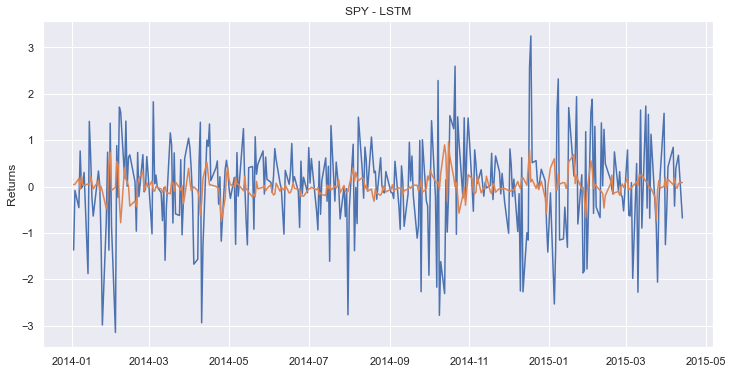

{'MAE': 0.0056523113944650025, 'RMSE': 0.007492577420864739, 'MAPE': 146.87614888357737, 'Theil-U': 0.8202901523401036}


In [138]:
ETF_params = {
              "SPY": {"epochs": 10, "lr":0.001},
              "DIA": {"epochs": 10, "lr":0.001},
              "QQQ": {"epochs": 10, "lr":0.001},
             }

Table4 = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

ETF = "SPY"

print("="*10 + ETF +"="*10)
train_data, valid_data, test_data =  get_etf_data(ETF)
model = LSTM()
train_model(model, train_data, valid_data, ETF_params[ETF])
results = evaluate_model(model, test_data)
predicted = predict(model, test_data)

Table4[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
print(results)